This is the final notebook for the CSE572 - Data Mining project titled "Spotify Song Clustering"

The notebook essentially has 2 sections -
1. Clustering my Spotify songs (based on the 9 attributed that spotify provides)
2. Classifying new songs into one of the clusters

In [1]:
# installing necessary packages
! pip install spotipy
! pip install kneed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.0/252.0 kB 4.3 MB/s eta 0:00:00


In [2]:
# all import statements

import sys
import yaml
import pprint
import spotipy
import numpy as np
import pandas as pd
import seaborn as sns
import spotipy.util as util
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sns.set()

In [3]:
my_spotify_config = {
    'username' : '*************************',
    'client_id' : '*****************************',
    'client_secret' : '*******************************',
    'redirect_uri' : 'http://localhost:8008/'
}

In [4]:
spotify_account_handle = spotipy.Spotify(
    auth_manager = spotipy.SpotifyOAuth(
    client_id = my_spotify_config['client_id'],
    client_secret = my_spotify_config['client_secret'],
    redirect_uri = my_spotify_config['redirect_uri'],
    scope = 'user-library-read',
    open_browser = False))

In [5]:
# Method - extracts the song names and URIs from the given playlist URI and account username
def get_playlist_info(username, playlist_uri):
    # helper variables
    offset = 0
    fetched_songs, uris, names, artists = [], [], [], []

    # extract playlist id and name from URI
    playlist_id = playlist_uri.split(':')[2]
    playlist_name = spotify_account_handle.user_playlist(username, playlist_id)['name']

    # fetch all songs in given playlist
    while True:
        response = spotify_account_handle.user_playlist_tracks(username, playlist_id, offset=offset)
        fetched_songs += response['items']
        if response['next'] is not None:
            offset += 100
        else:
            break

    # get track metadata
    for curr_song in fetched_songs:
        names.append(curr_song['track']['name'])
        artists.append(curr_song['track']['artists'][0]['name'])
        uris.append(curr_song['track']['uri'])

    return playlist_name, names, artists, uris

In [6]:
# Method - extracts features for every song in a given playlist
def get_features_for_playlist(df, username, uri):

    # get all track metadata from given playlist
    playlist_name, names, artists, uris = get_playlist_info(username, uri)

    # iterate through each track to get audio features and save data into dataframe
    for name, artist, track_uri in zip(names, artists, uris):

        # access audio features for given track URI via spotipy
        song_features = spotify_account_handle.audio_features(track_uri)

        # get relevant audio features
        feature_subset = [song_features[0][col] for col in df.columns if col not in ["name", "artist", "track_URI", "playlist"]]

        # compose a row of the dataframe by flattening the list of audio features
        row = [name, artist, track_uri, *feature_subset, playlist_name]
        df.loc[len(df.index)] = row
    return df

The below cell authenticates the user details and fetches the songs from the playlist URI passed as argument.
The playlist is my own custom playlist with 400+ songs from a varierty of genres and types.

In [7]:
df = pd.DataFrame(columns=['name', 'artist', 'track_URI', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'playlist'])

df = get_features_for_playlist(df, my_spotify_config['username'], 'spotify:playlist:0ZmhjkMqBkVwouvEtaiaQf')
df

Go to the following URL: https://accounts.spotify.com/authorize?client_id=7a41da656cc54ae6a54ffcfe1422107c&response_type=code&redirect_uri=http%3A%2F%2Flocalhost%3A8008%2F&scope=user-library-read
Enter the URL you were redirected to: http://localhost:8008/?code=AQAn0qC30C4uw68uABIfxzdLz1IpggzsojRTy8vDHu51eygltLy8On34eVomnXc__RSrqYKaGTt342eUjBMvEsaeLV6z9VOR0cYal3YQQU6siScIXIxiUGt-ZoxOv7Hy3so9r6mCyFP5Ir0DRdAlVERjNwp7__2mF95cQqreZclAYRhoRTWqBwokhQle


,name,artist,track_URI,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist
0,Champion,Cody William Falkosky,spotify:track:75hcGi4aZflcE46i2twZLc,0.218000,0.660,0.7050,0.000029,0.060,-5.116,0.0508,91.927,0.541,DM Project Test - 1
1,Beach House,The Chainsmokers,spotify:track:2bQhVQbV7VBzSOPo8mbkUR,0.174000,0.400,0.8380,0.000000,0.341,-4.491,0.0526,179.945,0.533,DM Project Test - 1
2,This Summer,Maroon 5,spotify:track:5uVji14OWpj9HMKLXdhjAv,0.000248,0.540,0.7660,0.000000,0.641,-5.148,0.0700,98.932,0.176,DM Project Test - 1
3,365,Zedd,spotify:track:2XWjPtKdi5sucFYtVav07d,0.339000,0.745,0.6930,0.000000,0.123,-5.479,0.0340,98.039,0.248,DM Project Test - 1
4,Sick Boy,The Chainsmokers,spotify:track:58kZ9spgxmlEznXGu6FPdQ,0.109000,0.663,0.5770,0.000000,0.120,-7.518,0.0531,89.996,0.454,DM Project Test - 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,Ghost - Piano Instrumental,Chilled Pig,spotify:track:7HPlvH0Qmhnexjt75cqpMZ,0.989000,0.610,0.0450,0.957000,0.124,-28.037,0.0458,141.981,0.279,DM Project Test - 1
446,Infinity - Piano Instrumental,Chilled Pig,spotify:track:3z7p8gVWxMr2n0umgl9vGE,0.988000,0.519,0.0744,0.945000,0.117,-24.197,0.0531,220.117,0.360,DM Project Test - 1
447,Running Up That Hill - Piano Instrumental,Chilled Pig,spotify:track:6IOCxRMxOYEj3LzpLnSqvr,0.994000,0.654,0.0210,0.863000,0.101,-31.420,0.0498,98.967,0.123,DM Project Test - 1
448,Dandelions - Piano Instrumental,Chilled Pig,spotify:track:6d36vTViY9LXaUs1jBiAa6,0.994000,0.486,0.0521,0.910000,0.103,-31.516,0.0607,200.060,0.402,DM Project Test - 1


Drop all unnecessary features that will not be used in song clustering. (Any non-numeric value)

In [8]:
non_features = ['name', 'artist', 'track_URI', 'playlist']
track_info = df[non_features]
features = df.drop(columns=non_features)
features.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.218000,0.660,0.705,0.000029,0.060,-5.116,0.0508,91.927,0.541
1,0.174000,0.400,0.838,0.000000,0.341,-4.491,0.0526,179.945,0.533
2,0.000248,0.540,0.766,0.000000,0.641,-5.148,0.0700,98.932,0.176
3,0.339000,0.745,0.693,0.000000,0.123,-5.479,0.0340,98.039,0.248
4,0.109000,0.663,0.577,0.000000,0.120,-7.518,0.0531,89.996,0.454


Scale the data above using StandardScaler()

In [9]:
scaler = StandardScaler()

scaled_features = scaler.fit_transform(features)

Run Principal Component Analysis to reduce the dimensionality (currently 9 - as 9 features exist for every song)

In [10]:
my_pca = PCA()
my_pca.fit(scaled_features);

In [11]:
variance_explained = my_pca.explained_variance_ratio_
variance_explained

array([0.41502123, 0.15633061, 0.11877072, 0.10429173, 0.08822397,
       0.05595086, 0.02796838, 0.02540399, 0.00803852])

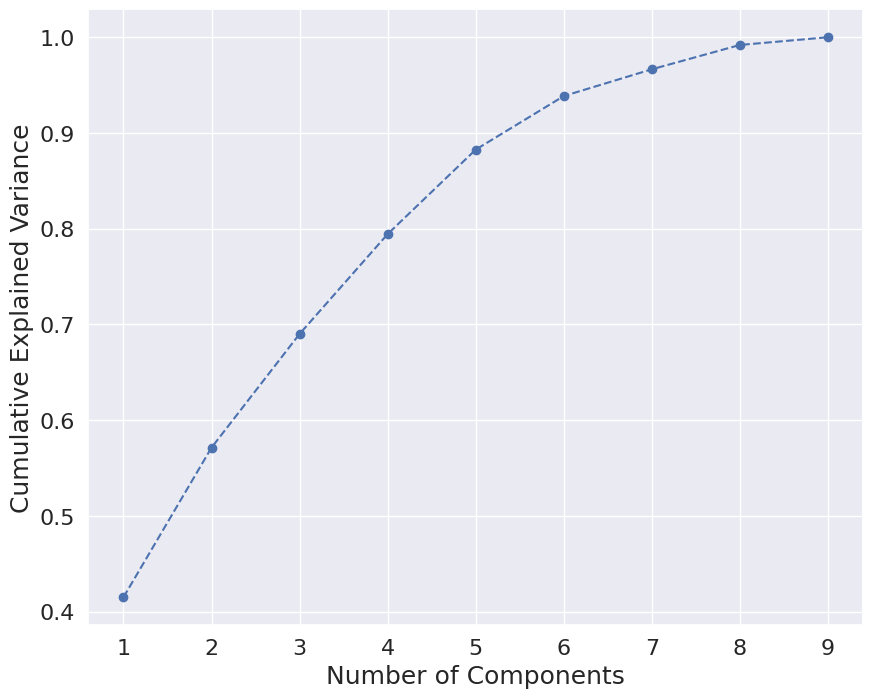

In [12]:
# plot a graph between the number of components and the varience explained by them
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(features.columns)+1), variance_explained.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components', fontsize=18)
plt.ylabel('Cumulative Explained Variance',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Generally, the number of componenets is chosen based on the fact that they can explain over the set threshold level of cumulative variance.
For this above graph, on visual inspection 7 looks like a good number for number of components as that explaines 90% of the variance.

In [13]:
for i, exp_var in enumerate(variance_explained.cumsum()):
    if exp_var >= 0.9:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components = n_comps)
pca.fit(scaled_features)
pca_transformed_features = pca.transform(scaled_features)

Number of components: 6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Optimal number of clusters 6


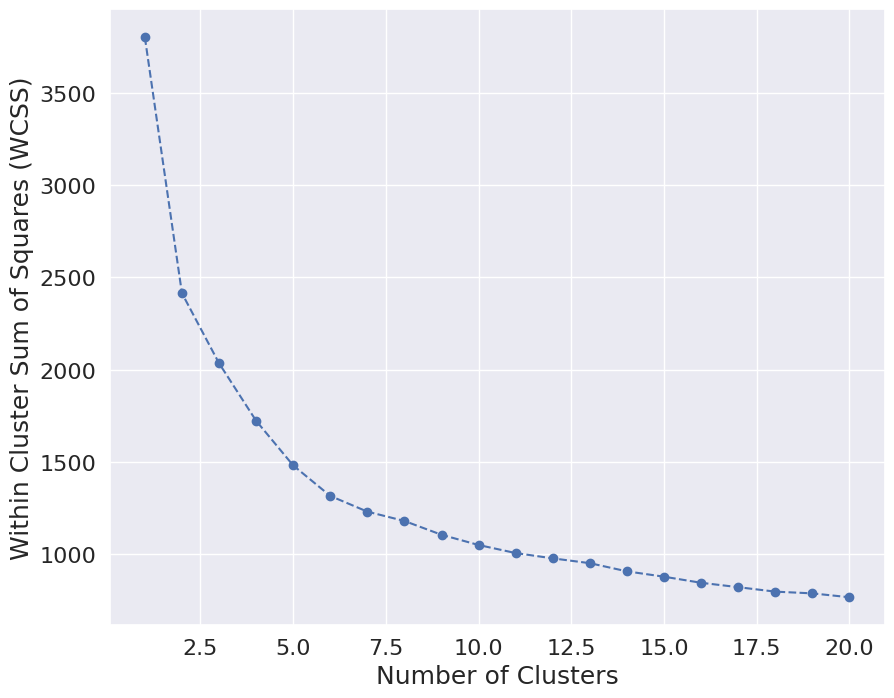

In [14]:
from kneed import KneeLocator
from sklearn.cluster import KMeans

# get within cluster sum of squares for each value of k
wcss = []
max_clusters = 21
for i in range(1, max_clusters):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(pca_transformed_features)
    wcss.append(kmeans_pca.inertia_)

# programmatically locate the elbow
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Optimal number of clusters", n_clusters)

# visualize the curve in order to locate the elbow
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, 21), wcss, marker='o', linestyle='--')
# plt.vlines(n_clusters, ymin=0, ymax=max(wcss), linestyles='dashed')
plt.xlabel('Number of Clusters', fontsize=18)
plt.ylabel('Within Cluster Sum of Squares (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Run KMeans++ to cluster the songs into 6 clusters as identified by the knee locator algorithm.

In [15]:
print("Number of clusters to use: ",n_clusters)
kmeans_pca = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans_pca.fit(pca_transformed_features)

Number of clusters to use:  6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6, random_state=42)

In [16]:
pca_transformed_kmeans_applied_df = pd.concat([features.reset_index(drop=True), pd.DataFrame(pca_transformed_features)], axis = 1)
pca_transformed_kmeans_applied_df.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
pca_transformed_kmeans_applied_df['Cluster'] = kmeans_pca.labels_
pca_transformed_kmeans_applied_df.sample(5)

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Cluster
443,0.9500,0.726,0.263,0.710000,0.1070,-16.297,0.0429,89.890,0.524,3.496054,-1.956191,0.027373,0.327734,0.048137,0.531294,3
13,0.5520,0.760,0.478,0.000000,0.0703,-5.574,0.0467,89.908,0.913,-0.075981,-2.163965,-0.127388,-0.620664,-0.483011,1.066393,2
231,0.1310,0.430,0.606,0.000000,0.1730,-5.115,0.0431,169.988,0.123,0.307476,2.850817,-0.805571,-0.341106,-0.352166,-0.571499,0
378,0.2760,0.791,0.558,0.000000,0.0859,-7.155,0.0661,95.077,0.872,-0.543904,-1.976059,0.083359,-0.571503,-0.438911,0.558405,2
156,0.0357,0.740,0.622,0.000048,0.3560,-4.608,0.0446,104.966,0.556,-1.101328,-0.541623,-0.507353,1.330571,-0.218058,-0.464836,4


Print the number of songs in each cluster

In [17]:
pca_transformed_kmeans_applied_df['Cluster'].value_counts()

Cluster
2    119
5    115
0     62
4     58
3     53
1     43
Name: count, dtype: int64

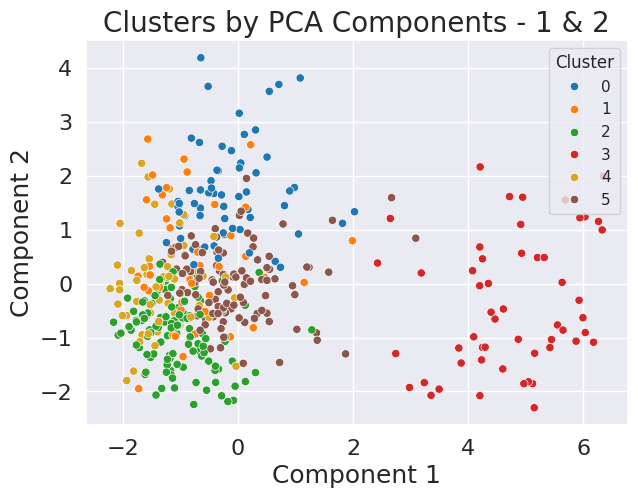

In [20]:
# extract 2 columns to plot on a graph
col1 = pca_transformed_kmeans_applied_df['Component 1']
col2 = pca_transformed_kmeans_applied_df['Component 2']

# initial grid size
fig = plt.figure(figsize=(7, 5))

# scatterplot and other labelings
sns.scatterplot(x=col1, y=col2, hue = pca_transformed_kmeans_applied_df['Cluster'], palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'goldenrod', 'tab:brown'])
plt.title('Clusters by PCA Components - 1 & 2', fontsize=20)
plt.xlabel("Component 1", fontsize=18)
plt.ylabel("Component 2", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

From the above plot between component 1 and 2 - It is evident why blue is a cluster. However, from the above graph along it is hard to observe the different cluster groups.

The main reason for this is that we are trying to visualize a 6 - dimension (6 component) space in just 2D.
If we plot different pairs of these components, we can likely observe the seperation between clusters.

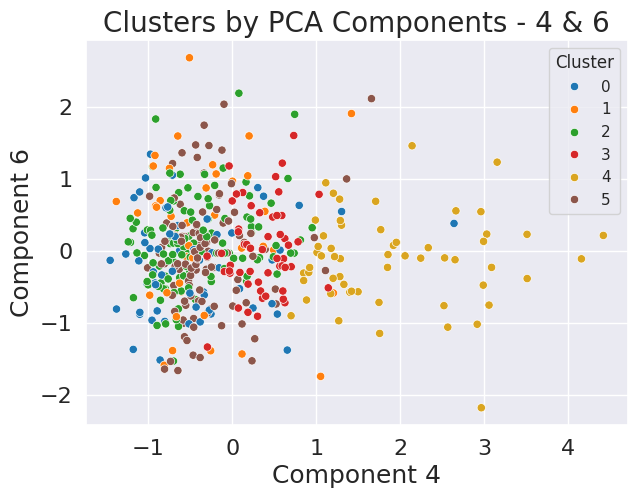

In [22]:
# extract 2 columns to plot on a graph
col1 = pca_transformed_kmeans_applied_df['Component 4']
col2 = pca_transformed_kmeans_applied_df['Component 6']

# initial grid size
fig = plt.figure(figsize=(7, 5))

# scatterplot and other labelings
sns.scatterplot(x=col1, y=col2, hue = pca_transformed_kmeans_applied_df['Cluster'], palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'goldenrod', 'tab:brown'])
plt.title('Clusters by PCA Components - 4 & 6', fontsize=20)
plt.xlabel("Component 4", fontsize=18)
plt.ylabel("Component 6", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

The above pair of components shows how green is separated from rest of the mix due to a different attribute that makes it unique.

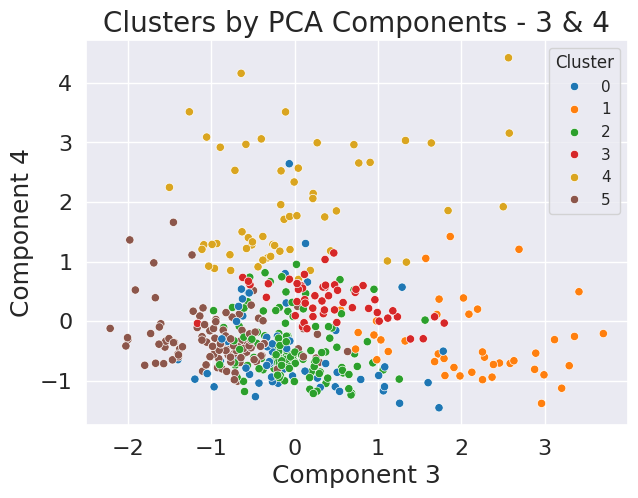

In [23]:
# extract 2 columns to plot on a graph
col1 = pca_transformed_kmeans_applied_df['Component 3']
col2 = pca_transformed_kmeans_applied_df['Component 4']

# initial grid size
fig = plt.figure(figsize=(7, 5))

# scatterplot and other labelings
sns.scatterplot(x=col1, y=col2, hue = pca_transformed_kmeans_applied_df['Cluster'], palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'goldenrod', 'tab:brown'])
plt.title('Clusters by PCA Components - 3 & 4', fontsize=20)
plt.xlabel("Component 3", fontsize=18)
plt.ylabel("Component 4", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Another pair of components which shows green in its own space, brown in its own space - clear mix between orange, red and yellow but still orange is mostly in the left, yellow is to the right.

Add the cluster ID as a column to the original dataframe

In [24]:
result_df = df
result_df = result_df.drop(columns = ['playlist', 'track_URI'])
result_df['Cluster'] = pca_transformed_kmeans_applied_df['Cluster']
result_df

,name,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Cluster
0,Champion,Cody William Falkosky,0.218000,0.660,0.7050,0.000029,0.060,-5.116,0.0508,91.927,0.541,5
1,Beach House,The Chainsmokers,0.174000,0.400,0.8380,0.000000,0.341,-4.491,0.0526,179.945,0.533,0
2,This Summer,Maroon 5,0.000248,0.540,0.7660,0.000000,0.641,-5.148,0.0700,98.932,0.176,4
3,365,Zedd,0.339000,0.745,0.6930,0.000000,0.123,-5.479,0.0340,98.039,0.248,5
4,Sick Boy,The Chainsmokers,0.109000,0.663,0.5770,0.000000,0.120,-7.518,0.0531,89.996,0.454,5
...,...,...,...,...,...,...,...,...,...,...,...,...
445,Ghost - Piano Instrumental,Chilled Pig,0.989000,0.610,0.0450,0.957000,0.124,-28.037,0.0458,141.981,0.279,3
446,Infinity - Piano Instrumental,Chilled Pig,0.988000,0.519,0.0744,0.945000,0.117,-24.197,0.0531,220.117,0.360,3
447,Running Up That Hill - Piano Instrumental,Chilled Pig,0.994000,0.654,0.0210,0.863000,0.101,-31.420,0.0498,98.967,0.123,3
448,Dandelions - Piano Instrumental,Chilled Pig,0.994000,0.486,0.0521,0.910000,0.103,-31.516,0.0607,200.060,0.402,3


### Analysing the song types in every cluster

***Cluster 0***

In [25]:
songs_0 = result_df.loc[result_df['Cluster'] == 0]
print(f"Number of songs in cluster 0: {len(songs_0)}")
songs_0

Number of songs in cluster 0: 62


,name,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Cluster
1,Beach House,The Chainsmokers,0.1740,0.400,0.838,0.000000,0.3410,-4.491,0.0526,179.945,0.533,0
22,So Far Away (feat. Jamie Scott & Romy Dya),Martin Garrix,0.4350,0.526,0.520,0.000000,0.1970,-7.985,0.0569,149.119,0.130,0
24,ocean eyes,Billie Eilish,0.8160,0.511,0.363,0.031700,0.0840,-7.650,0.0410,144.892,0.169,0
25,Ocean (feat. Khalid),Martin Garrix,0.5840,0.506,0.693,0.000096,0.0891,-7.265,0.0412,139.912,0.221,0
31,Somebody,The Chainsmokers,0.1920,0.320,0.630,0.000000,0.1020,-7.019,0.0493,203.443,0.323,0
...,...,...,...,...,...,...,...,...,...,...,...,...
383,O Gujariya,Shefali Alvares,0.0172,0.612,0.858,0.000007,0.2580,-8.800,0.0548,139.964,0.282,0
392,Dheere Dheere,Yo Yo Honey Singh,0.0399,0.730,0.580,0.000025,0.0703,-7.976,0.1240,167.915,0.550,0
393,Thandi Hawa,Ritviz,0.0558,0.619,0.558,0.009350,0.1600,-12.150,0.1770,195.004,0.514,0
395,,,0.6040,0.456,0.668,0.000145,0.1410,-7.795,0.0373,144.062,0.263,0


In [37]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
average_stats_0 = {}
print("Stats for cluster 0: \n")
for feature in features:
  temp = np.mean(songs_0[feature])
  average_stats_0[feature] = temp
  print(f"Average {feature} = {round(temp, 3)}")

Stats for cluster 0: 

Average acousticness = 0.189
Average danceability = 0.529
Average energy = 0.679
Average instrumentalness = 0.003
Average liveness = 0.151
Average loudness = -5.862
Average speechiness = 0.078
Average tempo = 162.486
Average valence = 0.372


***Cluster 0*** is composed of songs that are heavily instrumental with low speechiness and more acousticness.

Playlist perfect to vibe to while studying as it is soothing and not distracting because its all instrumental and hardly lyrical.

---

***Cluster 1***

In [26]:
songs_1 = result_df.loc[result_df['Cluster'] == 1]
print(f"Number of songs in cluster 1: {len(songs_1)}")
songs_1

Number of songs in cluster 1: 43


,name,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Cluster
14,Panda,Desiigner,0.02870,0.686,0.730,0.000000,0.3690,-5.504,0.412,145.251,0.271,1
21,Eastside (with Halsey & Khalid),benny blanco,0.55500,0.560,0.680,0.000000,0.1160,-7.648,0.321,89.391,0.319,1
45,I Like Me Better,Lauv,0.53400,0.753,0.505,0.000003,0.1040,-7.621,0.255,91.972,0.419,1
53,bad guy,Billie Eilish,0.32800,0.701,0.425,0.130000,0.1000,-10.965,0.375,135.128,0.562,1
58,COFFIN (feat. Eminem),Jessie Reyez,0.35400,0.581,0.595,0.000054,0.0921,-5.341,0.336,184.010,0.140,1
76,Lose Yourself,Eminem,0.00922,0.689,0.735,0.000720,0.3650,-4.545,0.267,171.403,0.059,1
83,7 rings,Ariana Grande,0.59100,0.777,0.317,0.000000,0.0881,-10.732,0.308,139.848,0.330,1
86,Starboy,The Weeknd,0.14100,0.679,0.587,0.000006,0.1370,-7.015,0.276,186.003,0.486,1
88,Side To Side,Ariana Grande,0.05280,0.649,0.736,0.000000,0.2350,-5.840,0.230,159.182,0.612,1
92,Godzilla (feat. Juice WRLD),Eminem,0.14500,0.808,0.745,0.000000,0.2920,-5.260,0.342,165.995,0.829,1


In [27]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
average_stats_1 = {}
print("Stats for cluster 1: \n")
for feature in features:
  temp = np.mean(songs_1[feature])
  average_stats_1[feature] = temp
  print(f"Average {feature} = {round(temp, 3)}")

Stats for cluster 1: 

Average acousticness = 0.209
Average danceability = 0.685
Average energy = 0.662
Average instrumentalness = 0.004
Average liveness = 0.15
Average loudness = -5.993
Average speechiness = 0.325
Average tempo = 133.33
Average valence = 0.526


***Cluster 1*** is composed of songs that are a bit slow in nature - lower tempo and loudness in general - just slower pop songs.

A playlist perfect for morning/evening walks or to play in the background while working.

---

***Cluster 2***

In [28]:
songs_2 = result_df.loc[result_df['Cluster'] == 2]
print(f"Number of songs in cluster 2: {len(songs_2)}")
songs_2

Number of songs in cluster 2: 119


,name,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Cluster
6,She Loves Control,Camila Cabello,0.166000,0.650,0.758,0.000000,0.0889,-4.020,0.1160,94.900,0.663,2
7,I'm a Hurricane,Wellmess,0.000164,0.626,0.838,0.018400,0.0432,-3.489,0.0349,124.976,0.654,2
8,Sugar (feat. Francesco Yates),Robin Schulz,0.018500,0.636,0.815,0.000000,0.1630,-5.098,0.0581,123.063,0.636,2
9,Old Town Road,Lil Nas X,0.057800,0.907,0.530,0.000002,0.1010,-6.112,0.1270,135.998,0.507,2
12,The Mack,Nevada,0.062600,0.711,0.882,0.000000,0.2260,-4.276,0.0576,106.017,0.560,2
...,...,...,...,...,...,...,...,...,...,...,...,...
388,Lak 28 Kudi Da,Diljit Dosanjh,0.076000,0.801,0.993,0.000022,0.1880,-4.106,0.0635,125.033,0.807,2
389,Suit Suit,Guru Randhawa,0.140000,0.767,0.869,0.000000,0.2210,-3.381,0.0908,98.208,0.751,2
390,Illegal Weapon,Garry Sandhu,0.488000,0.814,0.666,0.000042,0.1080,-6.555,0.0635,94.020,0.714,2
394,,,0.159000,0.845,0.659,0.012900,0.0782,-6.348,0.0373,125.965,0.547,2


In [29]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
average_stats_2 = {}
print("Stats for cluster 2: \n")
for feature in features:
  temp = np.mean(songs_2[feature])
  average_stats_2[feature] = temp
  print(f"Average {feature} = {round(temp, 3)}")

Stats for cluster 2: 

Average acousticness = 0.176
Average danceability = 0.749
Average energy = 0.733
Average instrumentalness = 0.002
Average liveness = 0.127
Average loudness = -5.207
Average speechiness = 0.066
Average tempo = 114.005
Average valence = 0.714


***Cluster 2*** is composed of energetic songs. The average energy is highest, the average speechiness is high and it can be verified by the number of rap songs by Eminem, Drake and KSI.

Overall a playlist perfect for gym or a time when you want to feel energetic!

---

***Cluster 3***

In [30]:
songs_3 = result_df.loc[result_df['Cluster'] == 3]
print(f"Number of songs in cluster 3: {len(songs_3)}")
songs_3

Number of songs in cluster 3: 53


,name,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Cluster
282,Satellite,Ben Abraham,0.950,0.267,0.0953,0.089600,0.1190,-19.439,0.0341,133.370,0.0894,3
327,Your Power,Billie Eilish,0.932,0.632,0.2840,0.000476,0.2330,-14.025,0.0801,129.642,0.2080,3
342,Get You The Moon (feat. Snøw),Kina,0.720,0.498,0.2350,0.000000,0.1440,-16.541,0.1880,118.917,0.0895,3
400,Stay - Instrumental,Ray Mak,0.972,0.585,0.2900,0.887000,0.1270,-16.978,0.0557,169.894,0.3970,3
401,golden hour - piano instrumental,Chilled Pig,0.986,0.383,0.0698,0.880000,0.0921,-27.261,0.0371,160.035,0.2650,3
402,I Ain't Worried - Piano Instrumental,Chilled Pig,0.992,0.756,0.1310,0.915000,0.1070,-24.895,0.0491,99.014,0.3240,3
403,Kiss Me More - Acoustic Instrumental,Edward Ong,0.919,0.753,0.2420,0.955000,0.1230,-13.985,0.0375,110.840,0.3700,3
404,Bad Habit - Piano Instrumental,Chilled Pig,0.993,0.625,0.0408,0.927000,0.0953,-26.103,0.0371,84.018,0.0650,3
405,SNAP - Acoustic Instrumental,Edward Ong,0.904,0.516,0.2150,0.917000,0.0969,-19.181,0.0406,170.033,0.1920,3
406,abcdefu - Acoustic Instrumental,Edward Ong,0.966,0.751,0.3080,0.942000,0.0894,-17.956,0.0496,121.965,0.3010,3


In [31]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
average_stats_3 = {}
print("Stats for cluster 3: \n")
for feature in features:
  temp = np.mean(songs_3[feature])
  average_stats_3[feature] = temp
  print(f"Average {feature} = {round(temp, 3)}")

Stats for cluster 3: 

Average acousticness = 0.935
Average danceability = 0.622
Average energy = 0.183
Average instrumentalness = 0.842
Average liveness = 0.116
Average loudness = -21.393
Average speechiness = 0.052
Average tempo = 129.884
Average valence = 0.297


***Cluster 3*** - This cluster has overall higher valence, energy and danceability. From a visual inspection I can infer that it contains upbeat songs with catchy music.

Cluster best for parties with songs that are great to dance to!

---

***Cluster 4***

In [32]:
songs_4 = result_df.loc[result_df['Cluster'] == 4]
print(f"Number of songs in cluster 4: {len(songs_4)}")
songs_4

Number of songs in cluster 4: 58


,name,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Cluster
2,This Summer,Maroon 5,0.000248,0.540,0.766,0.000000,0.641,-5.148,0.0700,98.932,0.1760,4
15,Rap God,Eminem,0.395000,0.709,0.843,0.000000,0.799,-2.660,0.3140,148.134,0.6250,4
19,Guns Blazing (feat. Dr. Dre & Sly Pyper),Eminem,0.017800,0.782,0.874,0.000002,0.444,-4.611,0.2760,119.959,0.6550,4
20,One Thing Right,Marshmello,0.064400,0.659,0.625,0.000000,0.582,-2.253,0.0450,88.042,0.4420,4
28,Outta My Head (with John Mayer),Khalid,0.017400,0.729,0.545,0.000274,0.369,-7.818,0.0316,103.012,0.5140,4
30,One Love,Blue,0.024300,0.683,0.722,0.000042,0.350,-4.039,0.0358,95.012,0.8540,4
36,All My Love,Major Lazer,0.008140,0.661,0.837,0.001900,0.304,-4.717,0.0388,115.091,0.3260,4
44,Payphone,Maroon 5,0.013600,0.739,0.756,0.000000,0.370,-4.828,0.0393,110.028,0.5220,4
51,Toothbrush,DNCE,0.122000,0.556,0.785,0.000000,0.468,-5.842,0.1330,104.978,0.8250,4
65,Numb,Linkin Park,0.003530,0.488,0.870,0.000000,0.484,-4.185,0.0421,110.072,0.2110,4


In [33]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
average_stats_4 = {}
print("Stats for cluster 4: \n")
for feature in features:
  temp = np.mean(songs_4[feature])
  average_stats_4[feature] = temp
  print(f"Average {feature} = {round(temp, 3)}")

Stats for cluster 4: 

Average acousticness = 0.123
Average danceability = 0.702
Average energy = 0.755
Average instrumentalness = 0.0
Average liveness = 0.439
Average loudness = -4.947
Average speechiness = 0.094
Average tempo = 113.622
Average valence = 0.558


***Cluster 4*** - is a hard one to understand based on the stats alone but based on the songs in this cluster, I can identify that they are the ones I listen to usually when I'm sad or low.
They are slow and calm (as can be seen from the energy and danceability)
They also have the lowest valence after cluster 0 but as cluster 0 is definetly instrumental only and not one that identifies with sad songs, cluster 4 is the one that can be marked as the one to go to when you are feeling low.

---

***Cluster 5***

In [34]:
songs_5 = result_df.loc[result_df['Cluster'] == 5]
print(f"Number of songs in cluster 5: {len(songs_5)}")
songs_5

Number of songs in cluster 5: 115


,name,artist,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Cluster
0,Champion,Cody William Falkosky,0.21800,0.660,0.705,0.000029,0.0600,-5.116,0.0508,91.927,0.541,5
3,365,Zedd,0.33900,0.745,0.693,0.000000,0.1230,-5.479,0.0340,98.039,0.248,5
4,Sick Boy,The Chainsmokers,0.10900,0.663,0.577,0.000000,0.1200,-7.518,0.0531,89.996,0.454,5
5,"Home (with Machine Gun Kelly, X Ambassadors & ...",mgk,0.00413,0.653,0.718,0.000000,0.0537,-5.232,0.2130,82.034,0.216,5
10,Destined For Greatness,Tobi & Manny,0.35200,0.866,0.611,0.012400,0.1840,-8.465,0.1290,104.994,0.176,5
...,...,...,...,...,...,...,...,...,...,...,...,...
374,Ye Tumhari Meri Baatein,Dominique,0.39300,0.351,0.552,0.000494,0.1120,-7.404,0.0273,87.769,0.319,5
375,Tune Jo Na Kaha,Pritam,0.77900,0.314,0.475,0.005390,0.3400,-12.380,0.0838,78.992,0.312,5
377,Saibo,Sachin-Jigar,0.73800,0.619,0.429,0.000013,0.1360,-7.867,0.0280,90.058,0.545,5
384,Buzz (feat. Badshah),Aastha Gill,0.23600,0.663,0.551,0.000036,0.0923,-8.272,0.1090,113.314,0.601,5


In [35]:
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
average_stats_5 = {}
print("Stats for cluster 5: \n")
for feature in features:
  temp = np.mean(songs_5[feature])
  average_stats_5[feature] = temp
  print(f"Average {feature} = {round(temp, 3)}")

Stats for cluster 5: 

Average acousticness = 0.24
Average danceability = 0.635
Average energy = 0.632
Average instrumentalness = 0.002
Average liveness = 0.123
Average loudness = -6.37
Average speechiness = 0.064
Average tempo = 101.339
Average valence = 0.36


***Cluster 5*** - is a lot similar to cluster 2 in terms of energy and rap/rock songs, but the songs of cluster 5 are a lot from wordy and longer in length as well.
These again contain a few rap songs as they tend to be a lot more lyrical, but also other pop songs with a greater emphasis on lyrics and less on music.

---

In [38]:
all_stats = {}
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

def getStats(cluster_stats, all_stats):
    for k, v in cluster_stats.items():
      if k not in all_stats:
        all_stats[k] = []

      all_stats[k].append(round(v,3))

    return

# iterating over cluster 0 - 5
for i in range(6):
  if i == 0:
    getStats(average_stats_0, all_stats)
  if i == 1:
    getStats(average_stats_1, all_stats)
  if i == 2:
    getStats(average_stats_2, all_stats)
  if i == 3:
    getStats(average_stats_3, all_stats)
  if i == 4:
    getStats(average_stats_4, all_stats)
  if i == 5:
    getStats(average_stats_5, all_stats)

stats_df = pd.DataFrame.from_dict(all_stats)
stats_df

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.189,0.529,0.679,0.003,0.151,-5.862,0.078,162.486,0.372
1,0.209,0.685,0.662,0.004,0.150,-5.993,0.325,133.330,0.526
2,0.176,0.749,0.733,0.002,0.127,-5.207,0.066,114.005,0.714
3,0.935,0.622,0.183,0.842,0.116,-21.393,0.052,129.884,0.297
4,0.123,0.702,0.755,0.000,0.439,-4.947,0.094,113.622,0.558
5,0.240,0.635,0.632,0.002,0.123,-6.370,0.064,101.339,0.360


In [39]:
mmscaler = MinMaxScaler()
radial_graph_df = pd.DataFrame(mmscaler.fit_transform(stats_df), columns=stats_df.columns)

In [40]:
radial_graph_df

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.081281,0.000000,0.867133,0.003563,0.108359,0.944363,0.095238,1.000000,0.179856
1,0.105911,0.709091,0.837413,0.004751,0.105263,0.936398,1.000000,0.523182,0.549161
2,0.065271,1.000000,0.961538,0.002375,0.034056,0.984191,0.051282,0.207140,1.000000
3,1.000000,0.422727,0.000000,1.000000,0.000000,0.000000,0.000000,0.466826,0.000000
4,0.000000,0.786364,1.000000,0.000000,1.000000,1.000000,0.153846,0.200877,0.625899
5,0.144089,0.481818,0.784965,0.002375,0.021672,0.913474,0.043956,0.000000,0.151079


In [41]:
import plotly.graph_objects as go

features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r = list(radial_graph_df.iloc[1]),
      theta = features,
      fill = 'toself',
      name = 'Cluster 1 - Slow Pop/Chill Songs'
))
fig.add_trace(go.Scatterpolar(
      r = list(radial_graph_df.iloc[2]),
      theta = features,
      fill = 'toself',
      name = 'Cluster 2 - Rap/Rock Songs'
))
fig.add_trace(go.Scatterpolar(
      r = list(radial_graph_df.iloc[3]),
      theta = features,
      fill = 'toself',
      name = 'Cluster 3 - Fast Pop/Party Songs'
))
fig.add_trace(go.Scatterpolar(
      r = list(radial_graph_df.iloc[4]),
      theta = features,
      fill = 'toself',
      name = 'Cluster 4 - Slow/Low/Sad Songs'
))
fig.add_trace(go.Scatterpolar(
      r = list(radial_graph_df.iloc[5]),
      theta = features,
      fill = 'toself',
      name = 'Cluster 5 - Lyrically heavy songs'
))
fig.add_trace(go.Scatterpolar(
      r = list(radial_graph_df.iloc[0]),
      theta = features,
      fill = 'toself',
      name = 'Cluster 0 - Instrumental Songs'
))



fig.update_layout(
  width = 1000,
  height = 500,
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-0.5, 1]
    )),
  showlegend=True
)

fig.show()

In [42]:
target_mood = ["study/instrumental", "walk/slow pop", "energetic/gym/rap", "party/dance/fast pop", "low/sad", "lyrically heavy/rock"]
detailed_df = stats_df
detailed_df['Target'] = target_mood
detailed_df

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,Target
0,0.189,0.529,0.679,0.003,0.151,-5.862,0.078,162.486,0.372,study/instrumental
1,0.209,0.685,0.662,0.004,0.150,-5.993,0.325,133.330,0.526,walk/slow pop
2,0.176,0.749,0.733,0.002,0.127,-5.207,0.066,114.005,0.714,energetic/gym/rap
3,0.935,0.622,0.183,0.842,0.116,-21.393,0.052,129.884,0.297,party/dance/fast pop
4,0.123,0.702,0.755,0.000,0.439,-4.947,0.094,113.622,0.558,low/sad
5,0.240,0.635,0.632,0.002,0.123,-6.370,0.064,101.339,0.360,lyrically heavy/rock


---
END OF SECTION 1
---

In [43]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [44]:
classification_features = df[["acousticness", "danceability", "liveness","energy", "instrumentalness", "loudness", "speechiness"]]

In [45]:
# scaler = MinMaxScaler()

# loudness = classification_features["loudness"].values
# loudness_scaled = scaler.fit_transform(loudness.reshape(-1, 1))
# classification_features["loudness"] = loudness_scaled

In [46]:
classification_features['Cluster'] = kmeans_pca.labels_

<ipython-input-46-170fd3c63624>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
classification_features

,acousticness,danceability,liveness,energy,instrumentalness,loudness,speechiness,Cluster
0,0.218000,0.660,0.060,0.7050,0.000029,-5.116,0.0508,5
1,0.174000,0.400,0.341,0.8380,0.000000,-4.491,0.0526,0
2,0.000248,0.540,0.641,0.7660,0.000000,-5.148,0.0700,4
3,0.339000,0.745,0.123,0.6930,0.000000,-5.479,0.0340,5
4,0.109000,0.663,0.120,0.5770,0.000000,-7.518,0.0531,5
...,...,...,...,...,...,...,...,...
445,0.989000,0.610,0.124,0.0450,0.957000,-28.037,0.0458,3
446,0.988000,0.519,0.117,0.0744,0.945000,-24.197,0.0531,3
447,0.994000,0.654,0.101,0.0210,0.863000,-31.420,0.0498,3
448,0.994000,0.486,0.103,0.0521,0.910000,-31.516,0.0607,3


In [48]:
X = classification_features.iloc[:, :-1].values
Y = classification_features.iloc[:,-1].values

In [49]:
print("X:", X.shape)
print("Y:", Y.shape)

X: (450, 7)
Y: (450,)


In [50]:
X_train, X_test, y_train, y_test=train_test_split(X,Y,test_size=0.2)

In [51]:
X_train[:,5]=scaler.fit_transform(X_train[:,5].reshape(-1, 1)).reshape(-1,)
X_test[:,5]=scaler.transform(X_test[:,5].reshape(-1, 1)).reshape(-1,)

1. KNN (with neighbors going from 2 - 10)

In [52]:
# K-nearest neighbors
acc=[]
for i in range(2,10):
  classifier = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  acc.append(accuracy_score(y_test, y_pred))
  print(f'{i}:{acc[-1]}')

2:0.6111111111111112
3:0.6
4:0.6111111111111112
5:0.6111111111111112
6:0.5888888888888889
7:0.6222222222222222
8:0.6222222222222222
9:0.6111111111111112


2. Gaussian Naive Bayes

In [53]:
# GNB
acc=[]

classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
acc.append(accuracy_score(y_test, y_pred))
print(f'{i}:{acc[-1]}')

9:0.6111111111111112


In [54]:
# Random Forest
acc=[]
for i in range(5,14):
  classifier = RandomForestClassifier(n_estimators = i, criterion = 'entropy', random_state = 0)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  acc.append(accuracy_score(y_test, y_pred))
  print(f'{i}:{acc[-1]}')

5:0.7222222222222222
6:0.7111111111111111
7:0.7444444444444445
8:0.7222222222222222
9:0.7444444444444445
10:0.7444444444444445
11:0.7444444444444445
12:0.7444444444444445
13:0.7444444444444445


3. Support Vector Machine

In [55]:
# SVM
acc=[]
for i in ['linear', 'poly', 'rbf', 'sigmoid']:
  classifier = SVC(kernel = i, random_state = 0)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  acc.append(accuracy_score(y_test, y_pred))
  print(f'{i}:{acc[-1]}')

linear:0.6444444444444445
poly:0.6333333333333333
rbf:0.6333333333333333
sigmoid:0.4444444444444444


In [56]:
classifier = SVC(kernel ='poly', random_state = 0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [57]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 0  0  0  0  1  8]
 [ 0  5  2  0  0  5]
 [ 0  0 22  0  1  7]
 [ 0  0  0  8  0  0]
 [ 0  0  0  0  8  0]
 [ 0  0  9  0  0 14]]


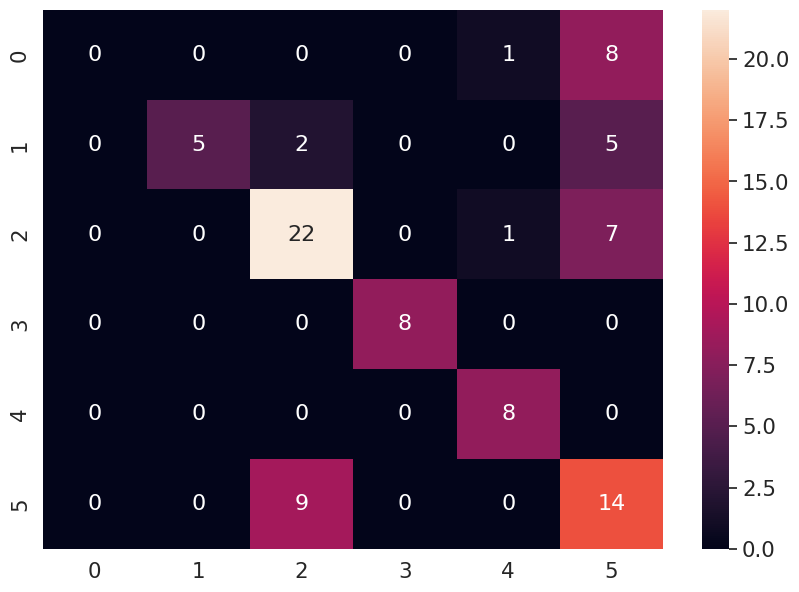

In [58]:
df_cm = pd.DataFrame(cm, range(6), range(6))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

---
END OF NOTEBOOK